<a href="https://colab.research.google.com/github/Arvinzaheri/data_colab_task/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Booksummaries.csv")
data.head()

,Unnamed: 0,Id,Genre,Summary
0,0,620,Roman clef Satire Childrens literature Sp...,Old Major the old boar on the Manor Farm call...
1,1,843,Science Fiction Novella Speculative fiction...,Alex a teenager living in nearfuture England ...
2,2,986,Existentialism Fiction Absurdist fiction N...,The text of The Plague is divided into five p...
3,3,1756,Philosophy,The argument of the Enquiry proceeds by a ser...
4,4,2080,Hard science fiction Science Fiction Specul...,The novel posits that space around the Milky ...


In [9]:
sample = data["Summary"][0]
print(sample)

 Old Major the old boar on the Manor Farm calls the animals on the farm for a meeting where he compares the humans to parasites and teaches the animals a revolutionary song Beasts of England When Major dies two young pigs Snowball and Napoleon assume command and turn his dream into a philosophy The animals revolt and drive the drunken and irresponsible Mr Jones from the farm renaming it Animal Farm They adopt Seven Commandments of Animalism the most important of which is All animals are equal Snowball attempts to teach the animals reading and writing food is plentiful and the farm runs smoothly The pigs elevate themselves to positions of leadership and set aside special food items ostensibly for their personal health Napoleon takes the pups from the farm dogs and trains them privately Napoleon and Snowball struggle for leadership When Snowball announces his plans to build a windmill Napoleon has his dogs chase Snowball away and declares himself leader Napoleon enacts changes to the gov

In [ ]:
print(data["Genre"][1])

 Science Fiction  Novella  Speculative fiction  Utopian and dystopian fiction  Satire  Fiction


#Word Clouds
Word clouds are visual representations of word frequency in a text corpus. They highlight the most frequent words, with larger font sizes indicating higher frequency

#sentiment polarity
using textblob api funcation to get the sentiment polarity of sentences and then plot it using matplotlib

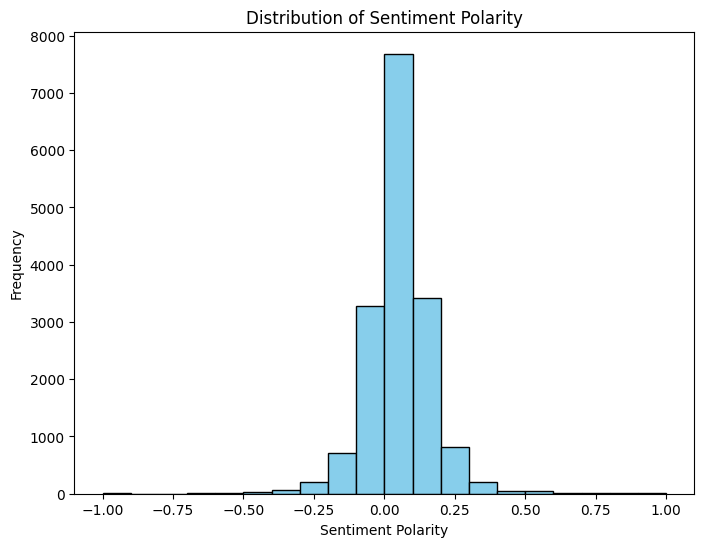

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob




# Calculate sentiment polarity scores
data["Sentiment_Polarity"] = data["Summary"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create a histogram of sentiment polarity scores
plt.figure(figsize=(8, 6))
plt.hist(data["Sentiment_Polarity"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Polarity")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


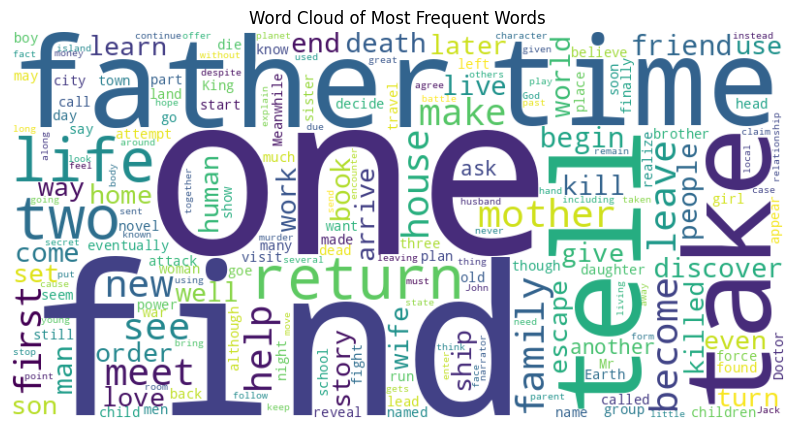

In [ ]:
from nltk.corpus import stopwords
import nltk
# Tokenize and remove stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
data["Tokens"] = data["Summary"].apply(lambda x: [word for word in x.split() if word not in stop_words])
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(data["Tokens"].explode()))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words")
plt.show()

<Axes: ylabel='Frequency'>

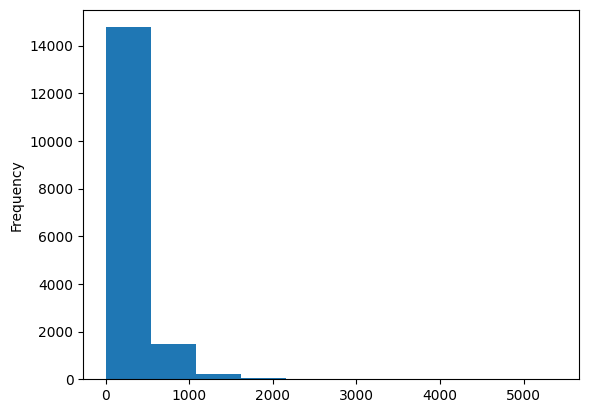

In [ ]:

# Bar plot for average review length
data["Summary_Length"] = data["Tokens"].apply(len)
data["Summary_Length"].plot(kind="hist")


In [ ]:
mean_lenght = data["Summary_Length"].mean()
mean_lenght

245.01358777703967

In [ ]:
median_len = data["Summary_Length"].median()
median_len

152.0

In [ ]:
max_length = data["Summary_Length"].max()
max_length

5393

#Finding the better model

we can go through different evstions and find the better model betwin Bart and DistilBart

In [ ]:
#!pip install -q torcheval

In [15]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

Bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
Bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

In [16]:


distil_tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
distil_model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")

In [24]:
import evaluate

rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")

In [25]:
Bart_model = Bart_model.to("cuda")
distil_model = distil_model.to("cuda")

In [ ]:
# Initialize scores
bart_scores = {"rouge1": 0, "rouge2": 0, "rougeLsum": 0, "bleu": 0}
distil_scores = {"rouge1": 0, "rouge2": 0, "rougeLsum": 0, "bleu": 0}

# Generate summaries for 32 random samples
random_indices = np.random.choice(data.index, 32, replace=False)
for index in random_indices:
    sample = data["Summary"][index]

    # Generate BART summary
    input_ids_bart = Bart_tokenizer.encode(sample, return_tensors="pt", max_length=512, truncation=True).to("cuda")
    generated_ids_bart = Bart_model.generate(input_ids_bart, max_length=75, num_beams=4)
    Bart_pre = Bart_tokenizer.decode(generated_ids_bart[0], skip_special_tokens=True)

    # Generate DistilBART summary
    input_ids_distil = distil_tokenizer.encode(sample, return_tensors="pt", max_length=512, truncation=True).to("cuda")
    generated_ids_distil = distil_model.generate(input_ids_distil, max_length=75, num_beams=4)
    Distil_pre = distil_tokenizer.decode(generated_ids_distil[0], skip_special_tokens=True)

    # Compute scores
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"])
    bart_scores.update(scorer.score(Bart_pre, sample))
    distil_scores.update(scorer.score(Distil_pre, sample))
    bart_scores["bleu"] += bleu_score.compute(predictions=[Bart_pre], references=[sample])["bleu"]
    distil_scores["bleu"] += bleu_score.compute(predictions=[Distil_pre], references=[sample])["bleu"]

# Calculate average scores
bart_scores = {k: v / 32 for k, v in bart_scores.items()}
distil_scores = {k: v / 32 for k, v in distil_scores.items()}


In [34]:
print(bart_scores)

{'rouge1': 0.41579940835767304, 'rouge2': 0.39541112730355854, 'rougeLsum': 0.40031301702025635, 'bleu': 0.1611629766960123}


In [35]:
print(distil_scores)

{'rouge1': 0.41227105676919223, 'rouge2': 0.39432053171427084, 'rougeLsum': 0.3951632428119408, 'bleu': 0.1529313633504888}


**based on the evaluation of the models they are nearly identical**

so we should test the models preformance(time)

In [36]:
#test the runing duration of the models on 16 samples
import time

bart_times = []
distil_times = []

random_indices_for_time = np.random.choice(data.index, 8, replace=False)

for index in random_indices_for_time:
    sample = data["Summary"][index]

    # Generate BART summary
    input_ids_bart = Bart_tokenizer.encode(sample, return_tensors="pt", max_length=512, truncation=True).to("cuda")
    start_time = time.time()
    generated_ids_bart = Bart_model.generate(input_ids_bart, max_length=75, num_beams=4)
    end_time = time.time()
    bart_times.append(end_time - start_time)

    # Generate DistilBART summary
    input_ids_distil = distil_tokenizer.encode(sample, return_tensors="pt", max_length=512, truncation=True).to("cuda")
    start_time = time.time()
    generated_ids_distil = distil_model.generate(input_ids_distil, max_length=75, num_beams=4)
    end_time = time.time()
    distil_times.append(end_time - start_time)

In [40]:
bart_avg = (sum(bart_times) / len(bart_times))
distil_avg = (sum(distil_times) / len(distil_times))

In [41]:
print(f"bart_avg: {bart_avg}")
print(f"distil_avg: {distil_avg}")

bart_avg: 0.8484213948249817
distil_avg: 0.5731780230998993


In [43]:
#we have about 17000 summary in the dataset
print((17000 * (bart_avg - distil_avg)) // 60, "minutes")

77.0 minutes


#Generating shoeter summaries

**using pretrained model(distilbart) from huggingface**

we can generate shoeter summaries using pretrained model(distilbart) from huggingface.

we will use accelerate library to accelerate the model with mixed precision and other optimizations.

also we will use dynamic padding for memeory and speed up the generation process.

In [ ]:
!pip install -q --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
from accelerate import Accelerator

# Initialize the accelerator
accelerator = Accelerator(mixed_precision="fp16")
print(accelerator.state)



# Use accelerator's device placement for the model and inputs
model = model.to(accelerator.device)



Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



In [ ]:
def generate_short_summary(text):
  # Tokenize the text
  inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
  #using accelerator
  inputs = inputs.to(accelerator.device)
  #print(inputs.shape)

  # Generate the summary with auto cast
  # Use accelerator's autocast for mixed precision
  with accelerator.autocast():
    summary_ids = model.generate(inputs, num_beams=4, max_length=76).to("cpu")

  return tokenizer.decode(summary_ids[0], skip_special_tokens=True)



In [ ]:
generate_short_summary(sample)

' Old Major the old boar on the Manor Farm calls the animals on the farm for a meeting where he compares the humans to parasites and teaches the animals a revolutionary song Beasts of England. When Major dies two young pigs Snowball and Napoleon assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm renaming'

In [ ]:
data["Short_Summary"] = data["Summary"].apply(generate_short_summary)

In [ ]:
data.head()

,Id,Genre,Summary,Sentiment_Polarity,Tokens,Summary_Length,Short_Summary
0,620,Roman clef Satire Childrens literature Sp...,Old Major the old boar on the Manor Farm call...,0.100747,"[Old, Major, old, boar, Manor, Farm, calls, an...",568,Old Major the old boar on the Manor Farm call...
1,843,Science Fiction Novella Speculative fiction...,Alex a teenager living in nearfuture England ...,0.025165,"[Alex, teenager, living, nearfuture, England, ...",594,Alex a teenager living in nearfuture England ...
2,986,Existentialism Fiction Absurdist fiction N...,The text of The Plague is divided into five p...,0.081628,"[The, text, The, Plague, divided, five, parts,...",642,In the town of Oran thousands of rats begin t...
3,1756,Philosophy,The argument of the Enquiry proceeds by a ser...,0.091933,"[The, argument, Enquiry, proceeds, series, inc...",1544,The argument of the Enquiry proceeds by a ser...
4,2080,Hard science fiction Science Fiction Specul...,The novel posits that space around the Milky ...,0.061330,"[The, novel, posits, space, around, Milky, Way...",448,The novel posits that space around the Milky ...


In [ ]:
#we save the data
data.to_csv("/content/drive/MyDrive/Booksummaries_with_short_summaries.csv")